In [ ]:
import warnings
warnings.simplefilter(action='ignore')

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Test").master("local").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [2]:
import pyspark.sql.functions as F

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import RFormula, VectorAssembler, VectorIndexer, MinMaxScaler, Imputer, ImputerModel
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, RandomForestClassificationModel, LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Ingestion

In [3]:
colnames = ["col" + str(c) for c in range(1, 280)] + ["target"]
schema = " DOUBLE, ".join(colnames) + " INT"

df0 = spark.read.csv("build_docker/arrhythmia.data", schema=schema, inferSchema=False, header=False, nullValue="?")

#### Missing Records

In [4]:
null_counts = df0.select([ F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df0.columns ]).toPandas().values.flatten()

for i in range(len(colnames)):
    if (null_counts[i] > 0):
        print(colnames[i], " Null Count: ", null_counts[i])

col11  Null Count:  8
col12  Null Count:  22
col13  Null Count:  1
col14  Null Count:  376
col15  Null Count:  1


#### Columns with constant value

In [5]:
unique_counts = df0.toPandas().nunique(axis=0).values
monotonous_cols = [("col"+str(i+1)) for i,c in enumerate(unique_counts) if c < 2]
monotonous_cols

['col20',
 'col68',
 'col70',
 'col84',
 'col132',
 'col133',
 'col140',
 'col142',
 'col144',
 'col146',
 'col152',
 'col157',
 'col158',
 'col165',
 'col205',
 'col265',
 'col275']

### Check Auto-Correlation of Data

In [8]:
corr = df0.select(*[
    c for c in colnames if c not in monotonous_cols
]).toPandas().corr().values

corr = np.triu(corr, k=1)

- Combination of column indices with abs(pearson_corr) > .9

In [19]:
indices = np.where(np.abs(corr) > .9)
## Better representation
list(zip(indices[0], indices[1]))

[(15, 147),
 (18, 150),
 (26, 156),
 (42, 170),
 (52, 178),
 (53, 179),
 (54, 180),
 (65, 189),
 (76, 199),
 (87, 209),
 (99, 219),
 (111, 228),
 (123, 239),
 (132, 248),
 (140, 257),
 (157, 196),
 (167, 196),
 (173, 192),
 (173, 202)]

In [ ]:
sns.set(font_scale=.8) # for label size
sns.heatmap(
    pd.DataFrame(
        np.triu(corr.values, k=1),
        index=corr.index,
        columns=corr.columns
    ),
    annot=True,
    cbar=False,
    cmap='gray_r'
)

plt.xlabel("Variable")
plt.ylabel("Variable")

fig = plt.gcf()
fig.set_size_inches(10,9)
fig.patch.set_facecolor('lightgray')
plt.show()

#### Data Summary (First 15 records)

In [9]:
df0.describe(colnames[:15])\
    .filter(F.col('summary') != "count")\
    .select(['summary'] + [F.round(F.col(c), 1).alias(c) for c in colnames[:15]])\
    .show()

+-------+----+----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+-----+
|summary|col1|col2| col3| col4| col5| col6| col7| col8| col9| col10| col11| col12| col13| col14|col15|
+-------+----+----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+-----+
|   mean|46.5| 0.6|166.2| 68.2| 88.9|155.2|367.2|169.9| 90.0|  33.7|  36.2|  48.9|  36.7| -13.6| 74.5|
| stddev|16.5| 0.5| 37.2| 16.6| 15.4| 44.8| 33.4| 35.6| 25.8|  45.4|  57.9|  29.3|  36.0| 127.2| 13.9|
|    min| 0.0| 0.0|105.0|  6.0| 55.0|  0.0|232.0|108.0|  0.0|-172.0|-177.0|-170.0|-135.0|-179.0| 44.0|
|    max|83.0| 1.0|780.0|176.0|188.0|524.0|509.0|381.0|205.0| 169.0| 179.0| 176.0| 166.0| 178.0|163.0|
+-------+----+----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+-----+



### Pre-processing features

In [11]:
toImpute_cols = ['col11', 'col12', 'col13', 'col15'] # col14 dropped due to majority missing
imputer = Imputer(strategy='mean', inputCols=toImpute_cols, outputCols=toImpute_cols)

input_cols = list(set(colnames) -set(['col14', 'target']) -set(monotonous_cols))
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
indexer = VectorIndexer(inputCol=assembler.getOutputCol(), outputCol='indexed_features', maxCategories=2)

prep_stages = [imputer, assembler, indexer]
prep_pipe = Pipeline().setStages(prep_stages).fit(df0)

#### Train/Test Split

In [12]:
(trainingData, testData) = prep_pipe.transform(df0).randomSplit([0.85, 0.15], seed=123456)

## Random Forest Performance

In [15]:
rf = RandomForestClassifier(
    labelCol="target", featuresCol='indexed_features',
    numTrees=30,
    maxDepth=30,
    seed=12345
).fit(trainingData)

predictions = rf.transform(testData)
evaluator = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="accuracy"
)

print("Random Forest Accuracy on Test data is: %.2f" % (evaluator.evaluate(predictions)))

Random Forest Accuracy on Test data is: 0.76


In [31]:
y_true = predictions.select(['target']).toPandas().values
y_pred = predictions.select(['prediction']).toPandas().values

print("Model Perf:\n", classification_report(y_true, y_pred))

Model Perf:
               precision    recall  f1-score   support

           1       0.80      0.96      0.87        49
           2       0.78      0.78      0.78         9
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
          10       0.50      0.50      0.50         8
          14       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         3

    accuracy                           0.76        76
   macro avg       0.26      0.28      0.27        76
weighted avg       0.66      0.76      0.71        76



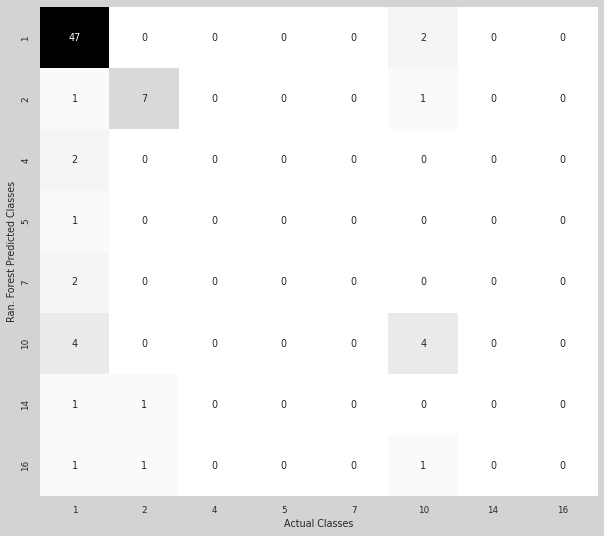

In [38]:
sns.set(font_scale=.8) # for label size
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_true))),
        index=sorted(np.unique(y_true)),
        columns=sorted(np.unique(y_true))
    ),
    annot=True,
    cbar=False,
    cmap='gray_r'
)

plt.xlabel("Actual Classes")
plt.ylabel("Ran. Forest Predicted Classes")

fig = plt.gcf()
fig.set_size_inches(10,9)
fig.patch.set_facecolor('lightgray')
plt.show()

### Random Forest Feature Importances (top 20)

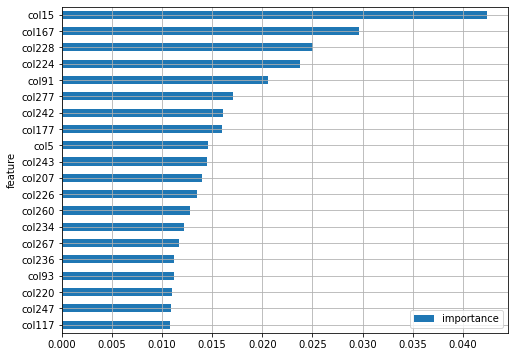

In [30]:
pd.DataFrame(list(zip(input_cols ,rf.featureImportances)), columns=['feature', 'importance'])\
    .set_index('feature')\
    .sort_values('importance', ascending=False)\
    .head(20)\
    .sort_values('importance')\
    .plot(kind='barh')

fig = plt.gcf()
fig.set_size_inches(8,6)

plt.grid()
plt.show()

## Logistic Regression Performance

In [43]:
lr = LogisticRegression(
    labelCol="target", featuresCol='indexed_features',
    maxIter=100,
    regParam=.05,
    elasticNetParam=0,
    fitIntercept=True
).fit(trainingData)

predictions = lr.transform(testData)
evaluator = MulticlassClassificationEvaluator(
    labelCol="target", predictionCol="prediction", metricName="accuracy"
)

print("Random Forest Accuracy on Test data is: %.2f" % (evaluator.evaluate(predictions)))

y_true = predictions.select(['target']).toPandas().values
y_pred = predictions.select(['prediction']).toPandas().values

print("Model Perf:\n", classification_report(y_true, y_pred))

Random Forest Accuracy on Test data is: 0.70
Model Perf:
               precision    recall  f1-score   support

         1.0       0.79      0.92      0.85        49
         2.0       0.57      0.44      0.50         9
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         2
        10.0       0.80      0.50      0.62         8
        14.0       0.00      0.00      0.00         2
        16.0       0.00      0.00      0.00         3

    accuracy                           0.70        76
   macro avg       0.24      0.21      0.22        76
weighted avg       0.66      0.70      0.67        76



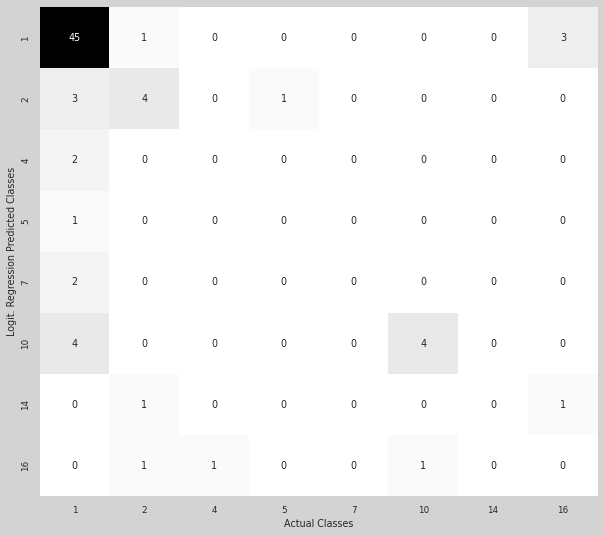

In [56]:
sns.set(font_scale=.8) # for label size
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_true))),
        index=sorted(np.unique(y_true)),
        columns=sorted(np.unique(y_true))
    ),
    annot=True,
    cbar=False,
    cmap='gray_r'
)

plt.xlabel("Actual Classes")
plt.ylabel("Logit. Regression Predicted Classes")

fig = plt.gcf()
fig.set_size_inches(10,9)
fig.patch.set_facecolor('lightgray')
plt.show()